<a href="https://colab.research.google.com/github/JingyiSu/prelim/blob/main/Pass_040922.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install -qq jovian
!pip install -qq datasets
!pip install -qq transformers
!pip install -qq seaborn
!pip install -qq sklearn

In [2]:
!nvidia-smi

Sun Apr 10 00:17:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import transformers
import torch.nn.functional as F
import torch.nn.utils.rnn
from tqdm.notebook import tqdm

from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import DefaultDataCollator
from datasets import load_dataset, concatenate_datasets, ClassLabel, Value

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00",
                        "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

# Load Data

In [4]:
DATASET_NAME = "code_x_glue_cc_defect_detection"

In [5]:
dataset = load_dataset("code_x_glue_cc_defect_detection")

Reusing dataset code_x_glue_cc_defect_detection (/users/PCS0256/jsu/.cache/huggingface/datasets/code_x_glue_cc_defect_detection/default/0.0.0/b0f3f36d6908feee44326eb5d257cfe4a02fe9fa50dfe441cad249b0e0ebfb11)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])
#dataset_train = load_dataset("code_x_glue_cc_defect_detection", split='train')
dataset

Dataset({
    features: ['id', 'func', 'target', 'project', 'commit_id'],
    num_rows: 27318
})

In [7]:
print(dataset.info)
print(dataset.split)
print(dataset.features)
print(dataset[0])

DatasetInfo(description='CodeXGLUE Defect-detection dataset, available at https://github.com/microsoft/CodeXGLUE/tree/main/Code-Code/Defect-detection\n\nGiven a source code, the task is to identify whether it is an insecure code that may attack software systems, such as resource leaks, use-after-free vulnerabilities and DoS attack. We treat the task as binary classification (0/1), where 1 stands for insecure code and 0 for secure code.\nThe dataset we use comes from the paper Devign: Effective Vulnerability Identification by Learning Comprehensive Program Semantics via Graph Neural Networks. We combine all projects and split 80%/10%/10% for training/dev/test.', citation='@inproceedings{zhou2019devign,\ntitle={Devign: Effective vulnerability identification by learning comprehensive program semantics via graph neural networks},\nauthor={Zhou, Yaqin and Liu, Shangqing and Siow, Jingkai and Du, Xiaoning and Liu, Yang},\nbooktitle={Advances in Neural Information Processing Systems},\npages=

In [8]:
print(dataset.shape)
print(dataset.num_columns)
print(dataset.num_rows)
len(dataset)

(27318, 5)
5
27318


27318

## Rename column

In [9]:
dataset = dataset.rename_column("target", "label")

In [10]:
dataset.features

{'id': Value(dtype='int32', id=None),
 'func': Value(dtype='string', id=None),
 'label': Value(dtype='bool', id=None),
 'project': Value(dtype='string', id=None),
 'commit_id': Value(dtype='string', id=None)}

## Convert Value to ClassLabel Object

In [11]:
# Creating a ClassLabel Object
df = dataset.to_pandas()
labels = df['label'].unique().tolist()
ClassLabels = ClassLabel(num_classes=len(labels), names=labels)

# Mapping Labels to IDs


def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example


dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)


Loading cached processed dataset at /users/PCS0256/jsu/.cache/huggingface/datasets/code_x_glue_cc_defect_detection/default/0.0.0/b0f3f36d6908feee44326eb5d257cfe4a02fe9fa50dfe441cad249b0e0ebfb11/cache-761256d31e549ebe.arrow
Loading cached processed dataset at /users/PCS0256/jsu/.cache/huggingface/datasets/code_x_glue_cc_defect_detection/default/0.0.0/b0f3f36d6908feee44326eb5d257cfe4a02fe9fa50dfe441cad249b0e0ebfb11/cache-fc270523ae366817.arrow


In [12]:
dataset.features

{'id': Value(dtype='int32', id=None),
 'func': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=[False, True], id=None),
 'project': Value(dtype='string', id=None),
 'commit_id': Value(dtype='string', id=None)}

In [13]:
df = dataset.to_pandas(dataset)

In [14]:
print(df.shape)
print(df.isnull().values.any())
df.sample(5)

(27318, 5)
False


,id,func,label,project,commit_id
11264,14026,static int ehci_state_fetchqtd(EHCIQueue *q)\n...,1,qemu,ef5b234477df80700b128f561f5877a0688a70c8
20121,25160,"static inline int check_ap(CPUARMState *env, i...",0,qemu,76e3e1bcaefe0da394f328854cb72f9449f23732
22477,6361,VirtIODevice *virtio_blk_init(DeviceState *dev...,1,qemu,69b302b2044a9a0f6d157d25b39a91ff7124c61f
12176,15162,"int do_drive_del(Monitor *mon, const QDict *qd...",0,qemu,922453bca6a927bb527068ae8679d587cfa45dbc
7793,9696,"static void omap_os_timer_write(void *opaque, ...",0,qemu,a8170e5e97ad17ca169c64ba87ae2f53850dab4c


In [15]:
df['func_length'] = df['func'].apply(lambda x: len(x))
#df = df.sort_values(by='id', ascending=True)
df.sample(5)

,id,func,label,project,commit_id,func_length
22912,10659,void avcodec_default_release_buffer(AVCodecCon...,0,FFmpeg,a09bb3ba5e018b81a659c199a84cd1d80c07d869,1087
6506,8104,static void co_sleep_cb(void *opaque)\n\n{\n\n...,1,qemu,6133b39f3c36623425a6ede9e89d93175fde15cd,114
24620,372,int attribute_align_arg avcodec_decode_video2(...,1,FFmpeg,1bc64c2814d409d3cc129c27c493ee915bebdc4a,1572
5266,6536,int ff_h264_update_thread_context(AVCodecConte...,0,FFmpeg,c8dcff0cdb17d0aa03ac729eba12d1a20f1f59c8,4326
13627,16992,static inline TranslationBlock *tb_find(CPUSta...,0,qemu,9b990ee5a3cc6aa38f81266fb0c6ef37a36c45b9,2032


In [16]:
#mean sentence length
np.mean(df['func_length'])

2023.9647119115602

In [17]:
#changing ratings to 0-numbering
#zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
#reviews['rating'] = reviews['rating'].apply(lambda x: zero_numbering[x])

# Data Pre-processing

ref: https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=Vea9edaaxSPO

## PRE_TRAINED_MODEL_NAME

In [18]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

# bert-base-uncased

# 'distilroberta-base'

# 'microsoft/graphcodebert-base'

# 'microsoft/codebert-base'

#'huggingface/CodeBERTa-small-v1'

# CodeBERT (Python, Java, JavaScript, PHP, Ruby, Go)

In [19]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)#, num_labels = len(label_dict)) # for transformer 4.x

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Filter #token >256

In [20]:
token_lens = []

for txt in df.func:
    tokens = tokenizer.encode(txt)  # ), max_length=512, truncation=True)
    token_lens.append(len(tokens))


Token indices sequence length is longer than the specified maximum sequence length for this model (866 > 512). Running this sequence through the model will result in indexing errors


/users/PCS0256/jsu/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


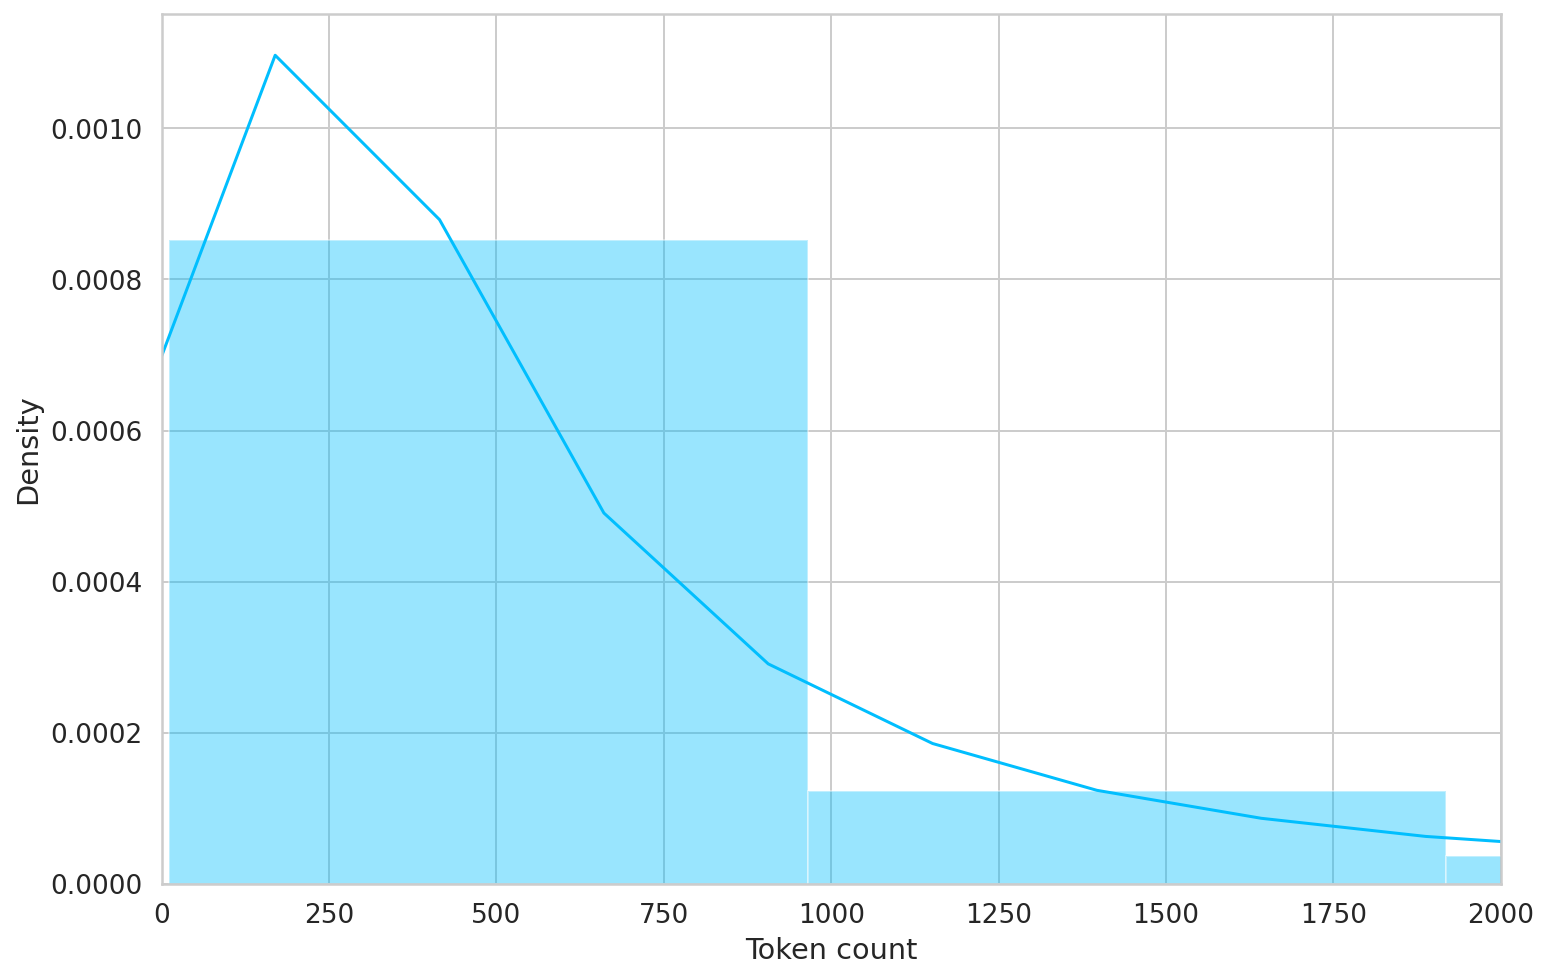

In [21]:
sns.distplot(token_lens)
plt.xlim([0, 2000]);
plt.xlabel('Token count');

In [22]:
df['len_tokens'] = token_lens

In [23]:
df = df[df['len_tokens'] <= 256]

## MAX_LEN

In [24]:
MAX_LEN = 256

## Dataset class

In [25]:
class CustomDataset(Dataset):

    def __init__(self, funcs, labels, tokenizer, max_len):
        self.funcs = funcs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.funcs)

    def __getitem__(self, item):
        func = str(self.funcs[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            func,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'func_text': func,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [26]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [27]:
df_train.shape, df_val.shape, df_test.shape

((10196, 7), (566, 7), (567, 7))

In [28]:
data_collator = DefaultDataCollator(return_tensors="pt")

In [29]:
possible_labels = df_train.label.unique()

In [30]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
    
label_dict

{1: 0, 0: 1}

## Dataloader

In [31]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CustomDataset(
        funcs=df.func.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        # collate_fn=data_collator, for some reason it removed 'func_text'
        shuffle=True,  # shuffles the data and then batches.
        num_workers=2  # optimization
    )


## BATCH_SIZE

In [32]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
df_train

,id,func,label,project,commit_id,func_length,len_tokens
19118,23884,"int qemu_strtoul(const char *nptr, const char ...",1,qemu,47d4be12c3997343e436c6cca89aefbbbeb70863,405,129
935,1154,static int find_unused_picture(MpegEncContext ...,0,FFmpeg,a553c6a347d3d28d7ee44c3df3d5c4ee780dba23,436,130
14898,18630,"static int compare_floats(const float *a, cons...",0,FFmpeg,e53c9065ca08a9153ecc73a6a8940bcc6d667e58,389,140
7469,9284,static inline void vring_used_idx_set(VirtQueu...,1,qemu,e0e2d644096c79a71099b176d08f465f6803a8b1,348,147
16980,21214,static void s390_pci_generate_error_event(uint...,0,qemu,5d1abf234462d13bef3617cc2c55b6815703ddf2,260,88
...,...,...,...,...,...,...,...
27220,26390,static void idr(H264Context *h){\n\n int i;...,0,FFmpeg,3dea28cc2ef22861347918b6740c4c05c46a6614,282,131
12402,15440,static int pci_set_default_subsystem_id(PCIDev...,0,qemu,5e434f4e60f8e5a9dadf324b3ee31c3ce0e80165,270,121
12862,16014,static inline uint32_t ucf64_stoi(float32 s)\n...,0,qemu,e8ede0a8bb5298a6979bcf7ed84ef64a64a4e3fe,148,49
2027,2470,static void FUNC(transquant_bypass8x8)(uint8_t...,0,FFmpeg,a246d06fe0dc6c2ea65e95327624b4537ff9bd0d,380,125


In [34]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['func_text', 'input_ids', 'attention_mask', 'labels'])

In [35]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


### Sample test

In [36]:
sample_txt = df["func"].iloc[-1]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

#print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')


   Tokens: ['static', 'inline', 'void', 'gen', '_', 'op', '_', 'eva', '##l', '_', 'f', '##bo', '(', 'tc', '##g', '##v', 'ds', '##t', ',', 'tc', '##g', '##v', 'sr', '##c', ',', 'unsigned', 'int', 'fcc', '_', 'offset', ')', '{', 'gen', '_', 'mo', '##v', '_', 'reg', '_', 'fcc', '##0', '(', 'ds', '##t', ',', 'sr', '##c', ',', 'fcc', '_', 'offset', ')', ';', 'gen', '_', 'mo', '##v', '_', 'reg', '_', 'fcc', '##1', '(', 'cpu', '_', 't', '##mp', '##0', ',', 'sr', '##c', ',', 'fcc', '_', 'offset', ')', ';', 'tc', '##g', '_', 'gen', '_', 'and', '_', 't', '##l', '(', 'ds', '##t', ',', 'ds', '##t', ',', 'cpu', '_', 't', '##mp', '##0', ')', ';', 'tc', '##g', '_', 'gen', '_', 'x', '##ori', '_', 't', '##l', '(', 'ds', '##t', ',', 'ds', '##t', ',', '0', '##x', '##1', ')', ';', '}']
Token IDs: [10763, 23881, 11675, 8991, 1035, 6728, 1035, 9345, 2140, 1035, 1042, 5092, 1006, 22975, 2290, 2615, 16233, 2102, 1010, 22975, 2290, 2615, 5034, 2278, 1010, 27121, 20014, 14420, 1035, 16396, 1007, 1063, 8991, 103

In [37]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [38]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=MAX_LEN,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

In [39]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

256


tensor([  101, 10763, 23881, 11675,  8991,  1035,  6728,  1035,  9345,  2140,
         1035,  1042,  5092,  1006, 22975,  2290,  2615, 16233,  2102,  1010,
        22975,  2290,  2615,  5034,  2278,  1010, 27121, 20014, 14420,  1035,
        16396,  1007,  1063,  8991,  1035,  9587,  2615,  1035, 19723,  1035,
        14420,  2692,  1006, 16233,  2102,  1010,  5034,  2278,  1010, 14420,
         1035, 16396,  1007,  1025,  8991,  1035,  9587,  2615,  1035, 19723,
         1035, 14420,  2487,  1006, 17368,  1035,  1056,  8737,  2692,  1010,
         5034,  2278,  1010, 14420,  1035, 16396,  1007,  1025, 22975,  2290,
         1035,  8991,  1035,  1998,  1035,  1056,  2140,  1006, 16233,  2102,
         1010, 16233,  2102,  1010, 17368,  1035,  1056,  8737,  2692,  1007,
         1025, 22975,  2290,  1035,  8991,  1035,  1060, 10050,  1035,  1056,
         2140,  1006, 16233,  2102,  1010, 16233,  2102,  1010,  1014,  2595,
         2487,  1007,  1025,  1065,   102,     0,     0,     0, 

In [40]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

256


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [41]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'static', 'inline', 'void', 'gen', '_', 'op', '_', 'eva', '##l', '_', 'f', '##bo', '(', 'tc', '##g', '##v', 'ds', '##t', ',', 'tc', '##g', '##v', 'sr', '##c', ',', 'unsigned', 'int', 'fcc', '_', 'offset', ')', '{', 'gen', '_', 'mo', '##v', '_', 'reg', '_', 'fcc', '##0', '(', 'ds', '##t', ',', 'sr', '##c', ',', 'fcc', '_', 'offset', ')', ';', 'gen', '_', 'mo', '##v', '_', 'reg', '_', 'fcc', '##1', '(', 'cpu', '_', 't', '##mp', '##0', ',', 'sr', '##c', ',', 'fcc', '_', 'offset', ')', ';', 'tc', '##g', '_', 'gen', '_', 'and', '_', 't', '##l', '(', 'ds', '##t', ',', 'ds', '##t', ',', 'cpu', '_', 't', '##mp', '##0', ')', ';', 'tc', '##g', '_', 'gen', '_', 'x', '##ori', '_', 't', '##l', '(', 'ds', '##t', ',', 'ds', '##t', ',', '0', '##x', '##1', ')', ';', '}', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

In [42]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)


In [43]:
print(last_hidden_state.shape)
print(bert_model.config.hidden_size)
print(pooled_output.shape)

torch.Size([1, 256, 768])
768
torch.Size([1, 768])


# Model

In [44]:
#BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).config

In [45]:
class CustomModel(nn.Module):

    def __init__(self, n_classes):
        super(CustomModel, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        #self.drop = nn.Dropout(p=0.3)

        self.lstm = nn.LSTM(self.bert.config.hidden_size,
                            self.bert.config.hidden_size, bidirectional=False)

        self.linear = nn.Linear(self.bert.config.hidden_size,
                                n_classes)  # fully connected layer

    def forward(self, input_ids, attention_mask):
        # output from bert
        sequence_output, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False  # for transformer 4.x
        )

        # Dropout
        #output = self.drop(pooled_output)

        # LSTM
        # extract the 1st token's embeddings
        lstm_output, (h, c) = self.lstm(sequence_output)
        hidden = torch.cat((lstm_output[:, -1, :self.bert.config.hidden_size],
                           lstm_output[:, 0, self.bert.config.hidden_size:]), dim=-1)

        # Linear
        #output = self.out(output)
        # assuming that you are only using the output of the last LSTM cell to perform classification
        linear_output = self.linear(
            hidden.view(-1, self.bert.config.hidden_size))

        output = linear_output

        return output


In [46]:
class_names = ['False', 'True']

In [47]:
model = CustomModel(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


We'll move the example batch of our training data to the GPU:

In [49]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4812, 0.5188],
        [0.4954, 0.5046],
        [0.5019, 0.4981],
        [0.4937, 0.5063],
        [0.4810, 0.5190],
        [0.4813, 0.5187],
        [0.4750, 0.5250],
        [0.4759, 0.5241],
        [0.4789, 0.5211],
        [0.4854, 0.5146],
        [0.4813, 0.5187],
        [0.4863, 0.5137],
        [0.4842, 0.5158],
        [0.4798, 0.5202],
        [0.4692, 0.5308],
        [0.4818, 0.5182]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [50]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Helpers

In [51]:
EPOCHS = 5

optimizer = optim.AdamW(model.parameters(), lr=2e-5)  # , correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [52]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [53]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [54]:
def train_epoch(model,  data_loader,  loss_fn,  optimizer,  device,  scheduler,  n_examples,
                epoch
                # loss_train_total
                ):

    model = model.train()
    losses = []
    correct_predictions = 0

    progress_bar = tqdm(train_data_loader,
                        desc=f'Epoch {epoch}',
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        #batch = tuple(b for b in batch)
        # model.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        #loss_train_total +=loss.item()
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        optimizer.zero_grad()

        #progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    #loss_train_avg = loss_train_total/len(data_loader)
    #tqdm.write(f'Training loss: {loss_train_avg}')

    accuracy = correct_predictions.to("cpu").numpy() / n_examples

    return accuracy, np.mean(losses)


In [55]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            accuracy = correct_predictions.to("cpu").numpy() / n_examples

    return accuracy, np.mean(losses)

# Training

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

Batch size: 16, 32

Learning rate (Adam): 5e-5, 3e-5, 2e-5

Number of epochs: 2, 3, 4

In [56]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(1, EPOCHS+1)):

    #loss_train_total = 0
    print('-' * 12)
    print(f'Progress {epoch - 1}/{EPOCHS}')

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        epoch
        # loss_train_total
    )
    print(f'Train loss: {train_loss}, Accuracy: {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss: {val_loss}, Accuracy: {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), f'best_model.bin')
        best_accuracy = val_acc

  0%|          | 0/5 [00:00<?, ?it/s]

------------
Progress 0/5


Epoch 1:   0%|          | 0/638 [00:00<?, ?it/s]

Train loss: 0.6767130768317787, Accuracy: 0.5755198116908592


  0%|          | 0/36 [00:00<?, ?it/s]

Val   loss: 0.6673579745822482, Accuracy: 0.6007067137809188

------------
Progress 1/5


Epoch 2:   0%|          | 0/638 [00:00<?, ?it/s]

Train loss: 0.6136743800019769, Accuracy: 0.6529030992546097


  0%|          | 0/36 [00:00<?, ?it/s]

Val   loss: 0.6318986175788773, Accuracy: 0.6148409893992933

------------
Progress 2/5


Epoch 3:   0%|          | 0/638 [00:00<?, ?it/s]

Train loss: 0.5168035262290587, Accuracy: 0.7390153001176932


  0%|          | 0/36 [00:00<?, ?it/s]

Val   loss: 0.6695598537723223, Accuracy: 0.6413427561837456

------------
Progress 3/5


Epoch 4:   0%|          | 0/638 [00:00<?, ?it/s]

Train loss: 0.4206885891765076, Accuracy: 0.8093369948999608


  0%|          | 0/36 [00:00<?, ?it/s]

Val   loss: 0.7354204348391957, Accuracy: 0.6466431095406361

------------
Progress 4/5


Epoch 5:   0%|          | 0/638 [00:00<?, ?it/s]

Train loss: 0.3441024287530808, Accuracy: 0.8557277363672028


  0%|          | 0/36 [00:00<?, ?it/s]

Val   loss: 0.8264073704679807, Accuracy: 0.6307420494699647

CPU times: user 19min 54s, sys: 4min 45s, total: 24min 39s
Wall time: 24min 54s


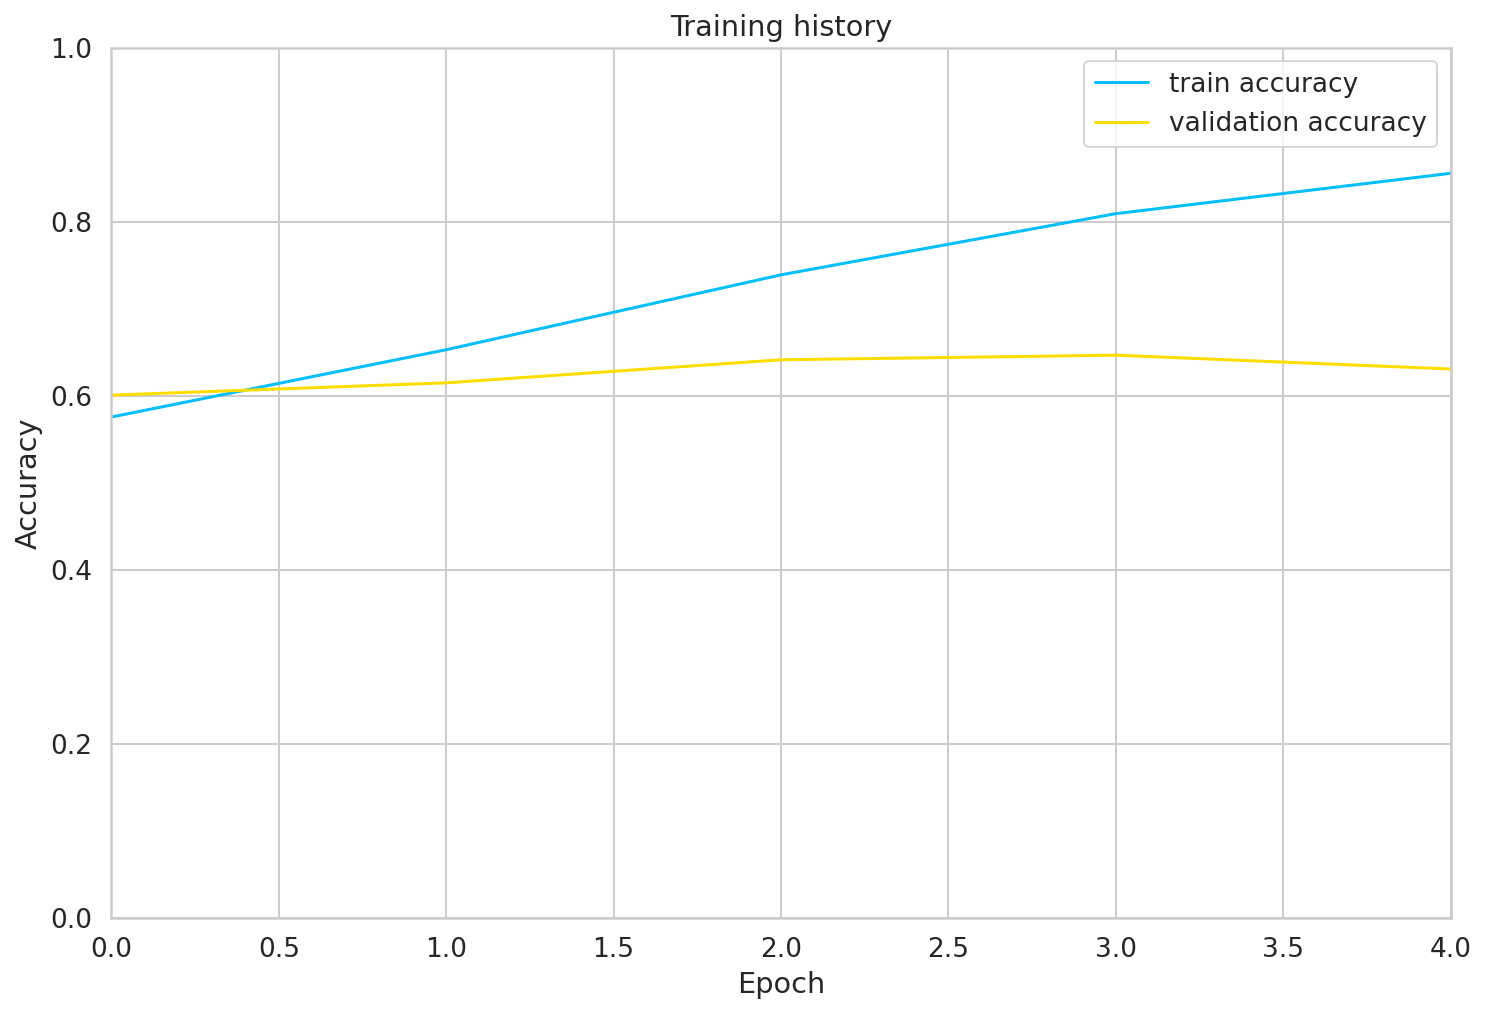

In [57]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1]);
plt.xlim([0, EPOCHS - 1]);
plt.legend()

## Can push pre-trained model and use later

In [58]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
# model = CustomModel(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [59]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)
test_acc.item()

  0%|          | 0/36 [00:00<?, ?it/s]

0.671957671957672

# Evaluation

In [60]:
def get_predictions(model, data_loader):
    model = model.eval()
    func_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["func_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            func_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(labels)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return func_texts, predictions, prediction_probs, real_values

In [61]:
y_func_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [62]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       False       0.74      0.69      0.72       337
        True       0.59      0.64      0.61       230

    accuracy                           0.67       567
   macro avg       0.66      0.67      0.66       567
weighted avg       0.68      0.67      0.67       567



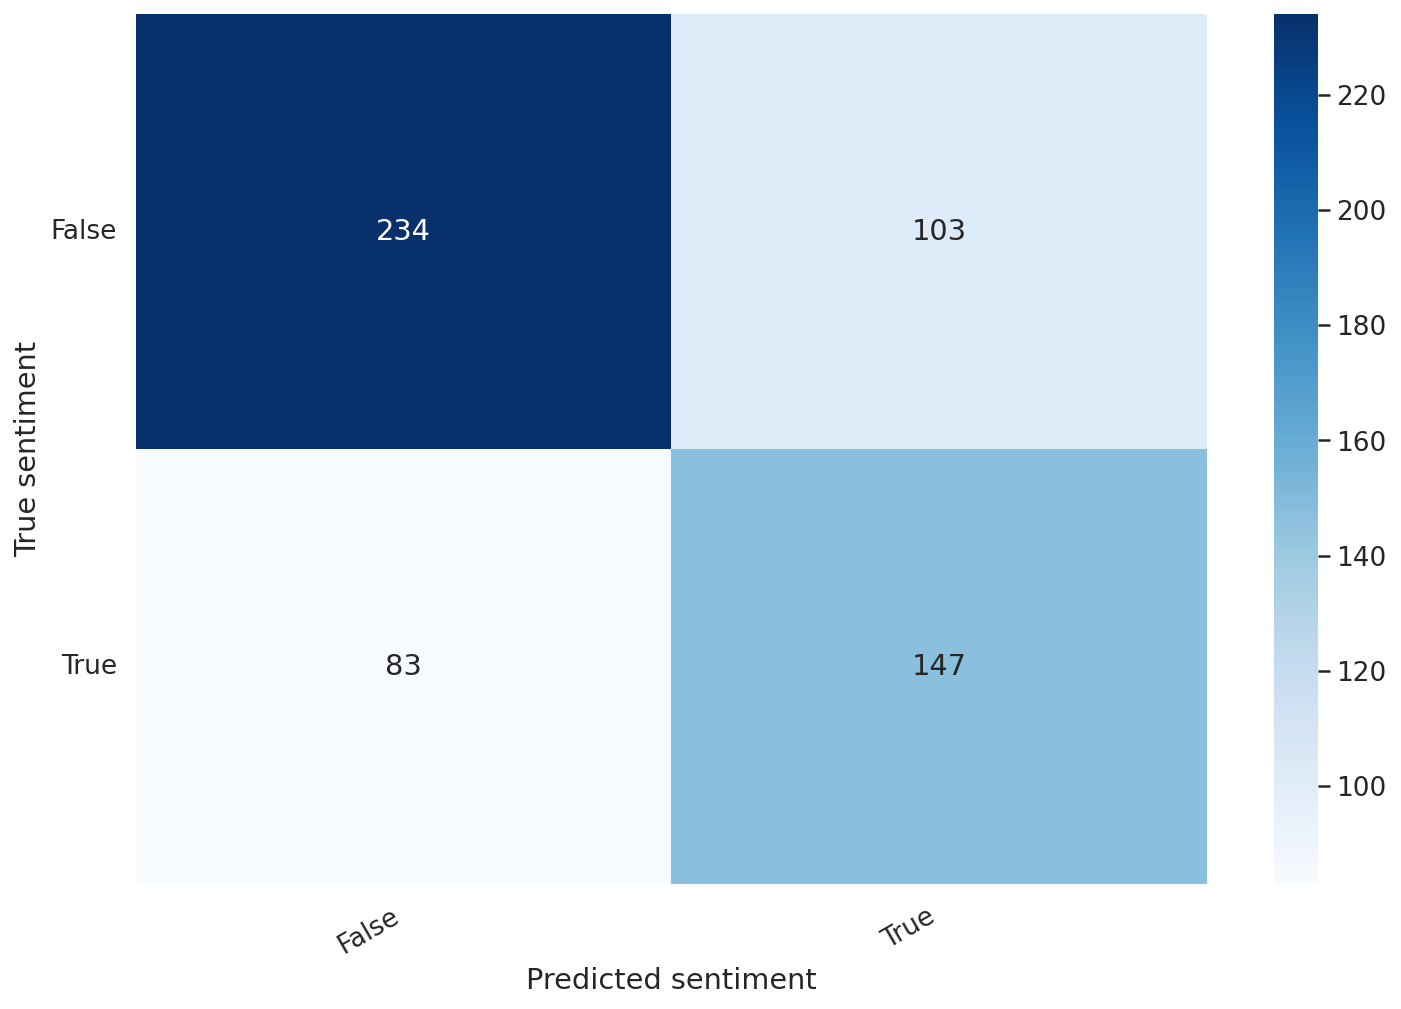

In [63]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(
        hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(
        hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Push to Hub

In [64]:
#from huggingface_hub import notebook_login

#notebook_login()

In [65]:
#model.push_to_hub("my-awesome-model")

# Manual test

In [66]:
idx = 2
func_text = y_func_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(func_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

static void default_show_tags(WriterContext *wctx, AVDictionary *dict)
{      AVDictionaryEntry *tag = NULL;      while ((tag =
av_dict_get(dict, "", tag, AV_DICT_IGNORE_SUFFIX))) {
printf("TAG:");          writer_print_string(wctx, tag->key,
tag->value);      }  }

True sentiment: False


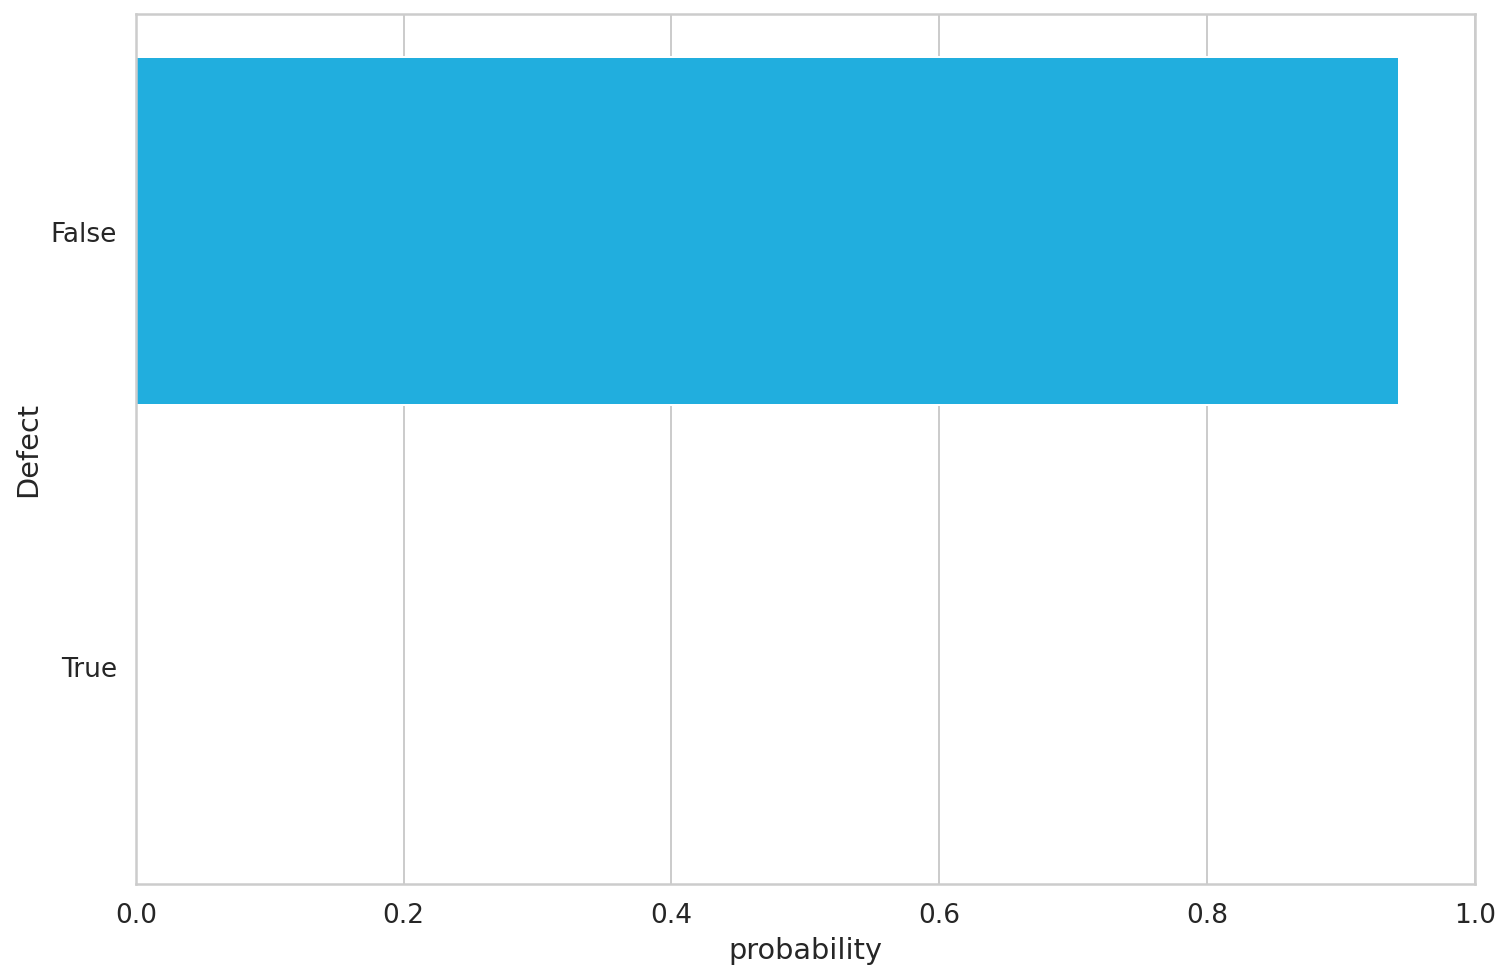

In [67]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Defect')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [68]:
func_text = '''
int max(int num1, int num2) {

   /* local variable declaration */
   int result;
 
   if (num1 > num2)
      result = num1;
   else
      result = num2;
 
   return result; 
}'''

In [69]:
encoded_func = tokenizer.encode_plus(
  func_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  #pad_to_max_length=True,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [70]:
input_ids = encoded_func['input_ids'].to(device)
attention_mask = encoded_func['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Func: {func_text}')
print(f'Label  : {class_names[prediction]}')

Func: 
int max(int num1, int num2) {

   /* local variable declaration */
   int result;
 
   if (num1 > num2)
      result = num1;
   else
      result = num2;
 
   return result; 
}
Label  : True
